# Machine Learning

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV, LassoLars, OrthogonalMatchingPursuit, BayesianRidge, ARDRegression, PassiveAggressiveRegressor, RANSACRegressor, TheilSenRegressor, HuberRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor

from joblib import dump

import math

## Découpage du dataset

In [2]:
df = pd.read_csv('../csv/donnees_clean.csv')

In [3]:
X = df.drop('charges', axis=1)
y = df['charges']

In [4]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.9,0,Oui,southwest,16884.92
1,18,male,33.8,1,Non,southeast,1725.55
2,28,male,33.0,3,Non,southeast,4449.46
3,33,male,22.7,0,Non,northwest,21984.47
4,32,male,28.9,0,Non,northwest,3866.86
...,...,...,...,...,...,...,...
1332,50,male,31.0,3,Non,northwest,10600.55
1333,18,female,31.9,0,Non,northeast,2205.98
1334,18,female,36.9,0,Non,southeast,1629.83
1335,21,female,25.8,0,Non,southwest,2007.94


## Nettoyage des données

In [5]:
def bmi(bmi):
    if bmi < 18.5:
        return "maigreur"
    elif bmi < 25:
        return "normal"
    elif bmi < 30:
        return "surpoids"
    elif bmi < 35:
        return "obesite_moderee"
    elif bmi < 40:
        return "obesite_severe"
    else:
        return "obesite_morbide"

In [6]:
# for i in df.index:
#     if df['smoker'][i] == 'Non':
#         df['bmi'][i] = df['bmi'][i] / 0.293656

In [7]:
X['bmi'] = X['bmi'].apply(lambda x : bmi(x))
del X['region']

X

,age,sex,bmi,children,smoker
0,19,female,surpoids,0,Oui
1,18,male,obesite_moderee,1,Non
2,28,male,obesite_moderee,3,Non
3,33,male,normal,0,Non
4,32,male,surpoids,0,Non
...,...,...,...,...,...
1332,50,male,obesite_moderee,3,Non
1333,18,female,obesite_moderee,0,Non
1334,18,female,obesite_severe,0,Non
1335,21,female,surpoids,0,Non


## Train_set & Test_set

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.95, random_state=42)
X_train.head()

,age,sex,bmi,children,smoker
1302,43,male,surpoids,0,Oui
296,19,male,surpoids,0,Oui
573,62,female,obesite_severe,1,Non
1132,52,female,maigreur,0,Non
471,18,female,obesite_moderee,0,Non


## Dummy Modèle

In [9]:
dummy = DummyRegressor()

In [10]:
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

-0.004178723670794193

## Création des Modèles

In [11]:
cat_var = ['smoker', 'sex', 'bmi']
num_var = ['age', 'children']

cat_transformer = OneHotEncoder(drop='if_binary')
num_transformer = RobustScaler()

encoder = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_var),
        ('num', num_transformer, num_var)
    ], 
    remainder='passthrough'
)

In [12]:
encoder.fit_transform(X).shape

(1337, 10)

In [13]:
models = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), OrthogonalMatchingPursuit(), BayesianRidge(), ARDRegression(), PassiveAggressiveRegressor(), AdaBoostRegressor(), BaggingRegressor(Lasso()), RandomForestRegressor(), ExtraTreesRegressor()]

### Résultats avec hyperparamètres sélectionnés

In [14]:
list_voting = []
for model in models:
    list_voting.append((f"{model.__class__.__name__}", model))

voting = StackingRegressor(list_voting, Ridge(alpha=0.3, solver='auto'))

models.append(voting)

list_models = []

for model in models:
    pipe = Pipeline([
        ('enc', encoder), 
        ('poly', PolynomialFeatures()), 
        ('model', model),
    ])

    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)
    score = round(score,4)

    prediction = pipe.predict(X_test)
    score_rmse = math.sqrt(mean_squared_error(y_test, prediction))

    list_models.append([f"{model.__class__.__name__}", f"{round(score *100, 2)}%", f"{round(score_rmse,2)}"])
    
    print(f"Nom du modèle : {model.__class__.__name__}, R2 score : {round(score *100, 2)}%, RMSE score : {round(score_rmse,2)}")

Nom du modèle : LinearRegression, R2 score : 90.85%, RMSE score : 4355.83
Nom du modèle : Lasso, R2 score : 92.83%, RMSE score : 3854.31
Nom du modèle : Ridge, R2 score : 92.55%, RMSE score : 3929.39


/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.816e+07, tolerance: 1.820e+07
  model = cd_fast.enet_coordinate_descent(


Nom du modèle : ElasticNet, R2 score : 50.55%, RMSE score : 10123.77
Nom du modèle : OrthogonalMatchingPursuit, R2 score : 91.84%, RMSE score : 4112.37
Nom du modèle : BayesianRidge, R2 score : 92.61%, RMSE score : 3914.89
Nom du modèle : ARDRegression, R2 score : 92.8%, RMSE score : 3863.42
Nom du modèle : PassiveAggressiveRegressor, R2 score : 92.96%, RMSE score : 3818.95
Nom du modèle : AdaBoostRegressor, R2 score : 65.78%, RMSE score : 8421.3


/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.568e+09, tolerance: 1.996e+07
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.600e+07, tolerance: 1.824e+07
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Nom du modèle : BaggingRegressor, R2 score : 92.86%, RMSE score : 3846.07
Nom du modèle : RandomForestRegressor, R2 score : 88.3%, RMSE score : 4924.76
Nom du modèle : ExtraTreesRegressor, R2 score : 82.96%, RMSE score : 5943.22


/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.816e+07, tolerance: 1.820e+07
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.063e+07, tolerance: 1.812e+07
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Nom du modèle : StackingRegressor, R2 score : 92.82%, RMSE score : 3856.63


In [15]:
df_list_models = pd.DataFrame(list_models,columns=['modele', "r2_score", "score_rmse"])

df_list_models.sort_values('r2_score', ascending=False)

,modele,r2_score,score_rmse
7,PassiveAggressiveRegressor,92.96%,3818.95
9,BaggingRegressor,92.86%,3846.07
1,Lasso,92.83%,3854.31
12,StackingRegressor,92.82%,3856.63
6,ARDRegression,92.8%,3863.42
5,BayesianRidge,92.61%,3914.89
2,Ridge,92.55%,3929.39
4,OrthogonalMatchingPursuit,91.84%,4112.37
0,LinearRegression,90.85%,4355.83
10,RandomForestRegressor,88.3%,4924.76


## Sélection et enregistrement du Modèle

In [16]:
model = PassiveAggressiveRegressor()

pipe = Pipeline([
    ('enc', encoder), 
    ('poly', PolynomialFeatures()), 
    ('model', model)
])

pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
score = round(score,4)

prediction = pipe.predict(X_test)
score_rmse = math.sqrt(mean_squared_error(y_test, prediction))

print(f"Nom du modèle : {model.__class__.__name__}, R2 score : {round(score *100, 2)}%, RMSE score : {round(score_rmse,2)}")

dump(pipe, f"../models/{model.__class__.__name__}.pkl")

Nom du modèle : PassiveAggressiveRegressor, R2 score : 92.94%, RMSE score : 3826.12


['../models/PassiveAggressiveRegressor.pkl']

In [17]:
pipe = Pipeline([
    ('enc', encoder), 
    ('poly', PolynomialFeatures()), 
    ('model', voting),
])

pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
score = round(score,4)

prediction = pipe.predict(X_test)
score_rmse = math.sqrt(mean_squared_error(y_test, prediction))

print(f"Nom du modèle : {voting.__class__.__name__}, R2 score : {round(score *100, 2)}%, RMSE score : {round(score_rmse,2)}")

dump(pipe, f"../models/{voting.__class__.__name__}2.pkl")

/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.816e+07, tolerance: 1.820e+07
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.529e+07, tolerance: 1.766e+07
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Nom du modèle : StackingRegressor, R2 score : 92.54%, RMSE score : 3930.94


['../models/StackingRegressor2.pkl']

## Learning curves

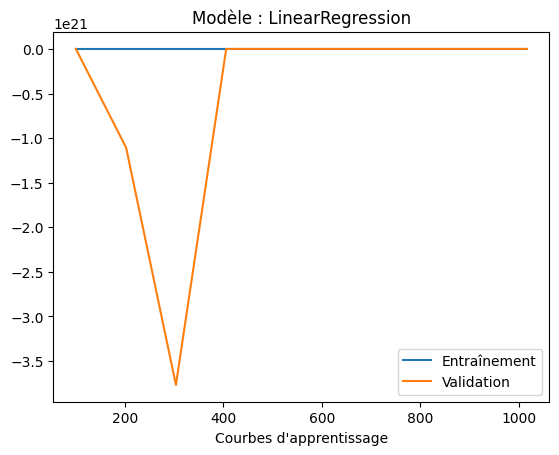

/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.639e+07, tolerance: 2.904e+06
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.773e+06, tolerance: 4.206e+06
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

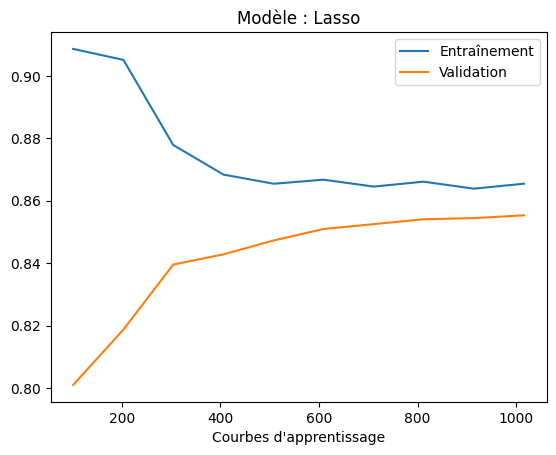

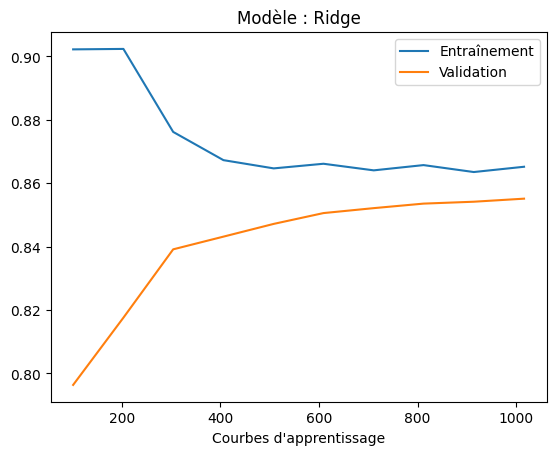

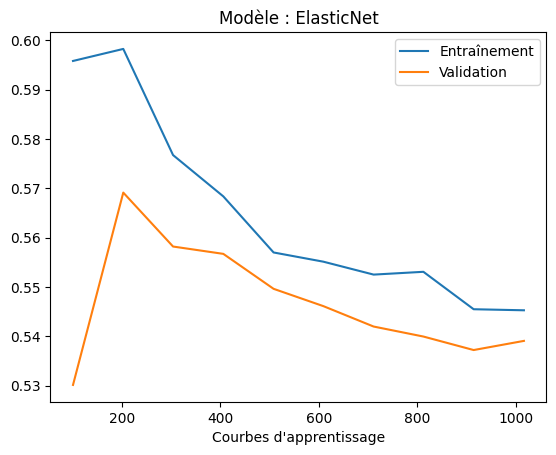

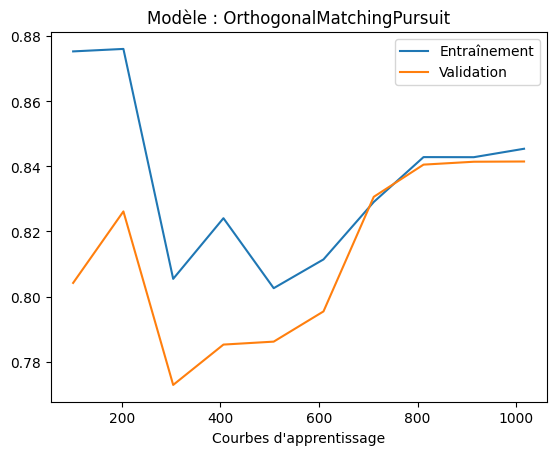

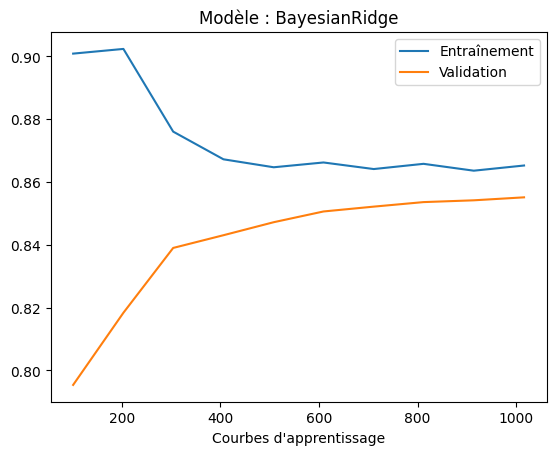

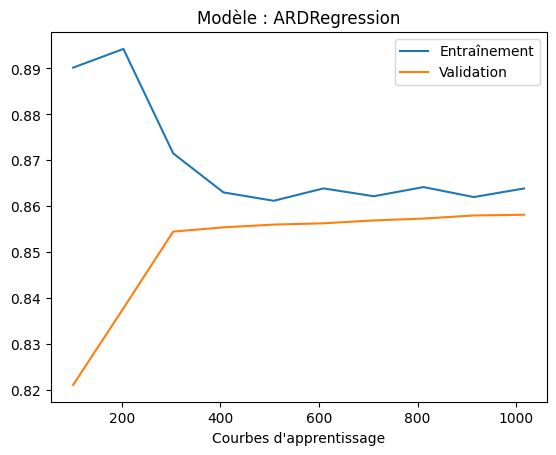

/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/apprenant/.loc

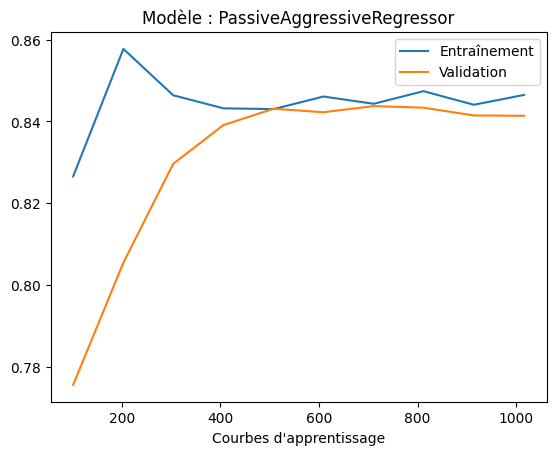

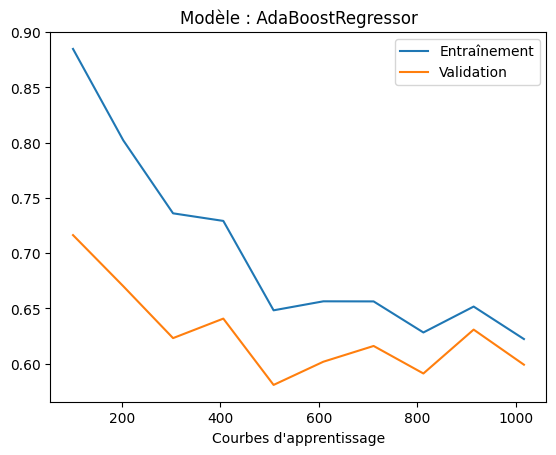

/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.333e+07, tolerance: 1.261e+06
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.284e+06, tolerance: 1.739e+06
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

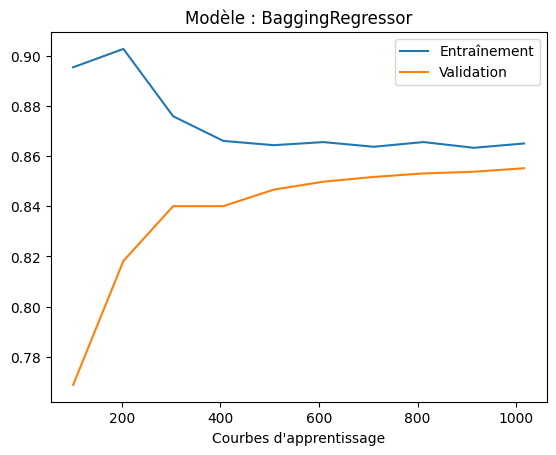

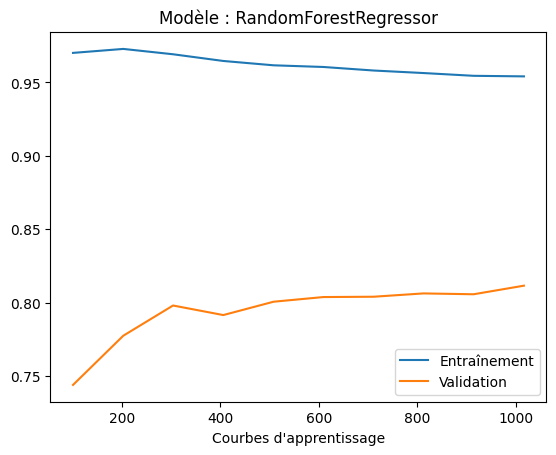

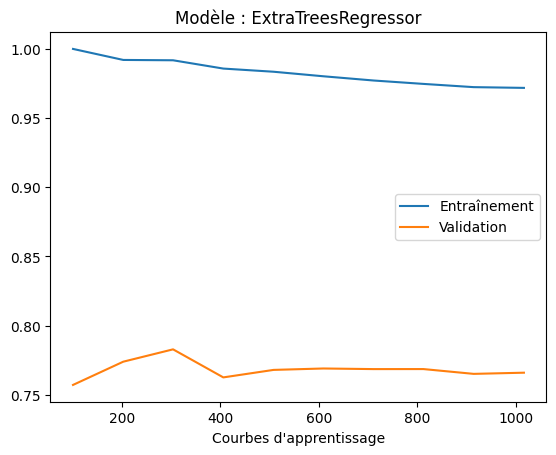

/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.268e+08, tolerance: 9.782e+05
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.078e+06, tolerance: 9.186e+05
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/.local/lib/python

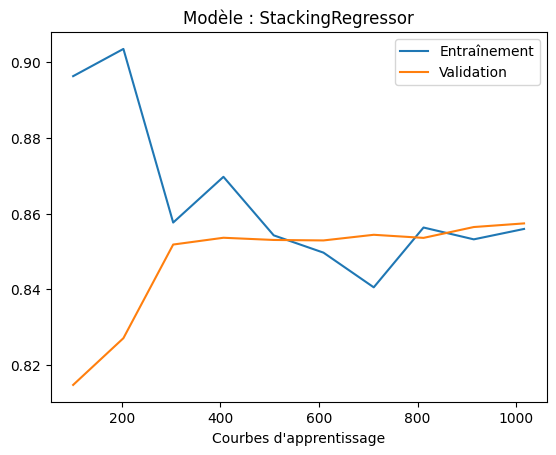

In [18]:
for model in models:
    pipe = Pipeline([
        ('enc', encoder), 
        ('poly', PolynomialFeatures()), 
        ('model', model),
    ])

    N, train_score, val_score = learning_curve(pipe, X_train, y_train, train_sizes=np.linspace(0.1,1,10), cv=5)

    # print(N)
    # print(train_score)
    # print(val_score)

    plt.plot(N, train_score.mean(axis=1), label='Entraînement')
    plt.plot(N, val_score.mean(axis=1), label='Validation')
    plt.title(f"Modèle : {model.__class__.__name__}")
    plt.xlabel('Courbes d\'apprentissage')
    plt.legend()
    plt.show()